In [2]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'   # better inline figure resolution
plt.style.use('tableau-colorblind10')

### Creating a simple MLP

In [2]:
class ToyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 2
        self.output_dim = 1
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, 3),
            nn.ReLU(),
            nn.Linear(3, 7),
            nn.ReLU(),
            nn.Linear(7, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, data):
        return self.model(data)
    
    def classify(self, data):
        with torch.no_grad():
            labels = torch.heaviside(2*self.model(data) - 1, torch.tensor([0.0])).to(torch.int)
        return labels
    
    def train(self, data, labels, epochs=1000, learning_rate=0.01):
        # Setup
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_function = nn.BCELoss()

        # Convert data to PyTorch tensors
        data_tensor = torch.tensor(data, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

        # Run the training  
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            output = self.model(data_tensor)
            loss = self.loss_function(output, labels_tensor)
            loss.backward()
            self.optimizer.step()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item()}")
        print(f"Final Loss = {loss.item()}")    

### Testing it on toy data

In [3]:
locations = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
normal = lambda location : np.random.normal(loc = location, scale = 0.5, size=(100, 2))
data = np.array([normal(location) for location in locations])
data = np.concatenate(data, axis=0)
labels = np.array([0] * 3 * 100 + [1] * 100)

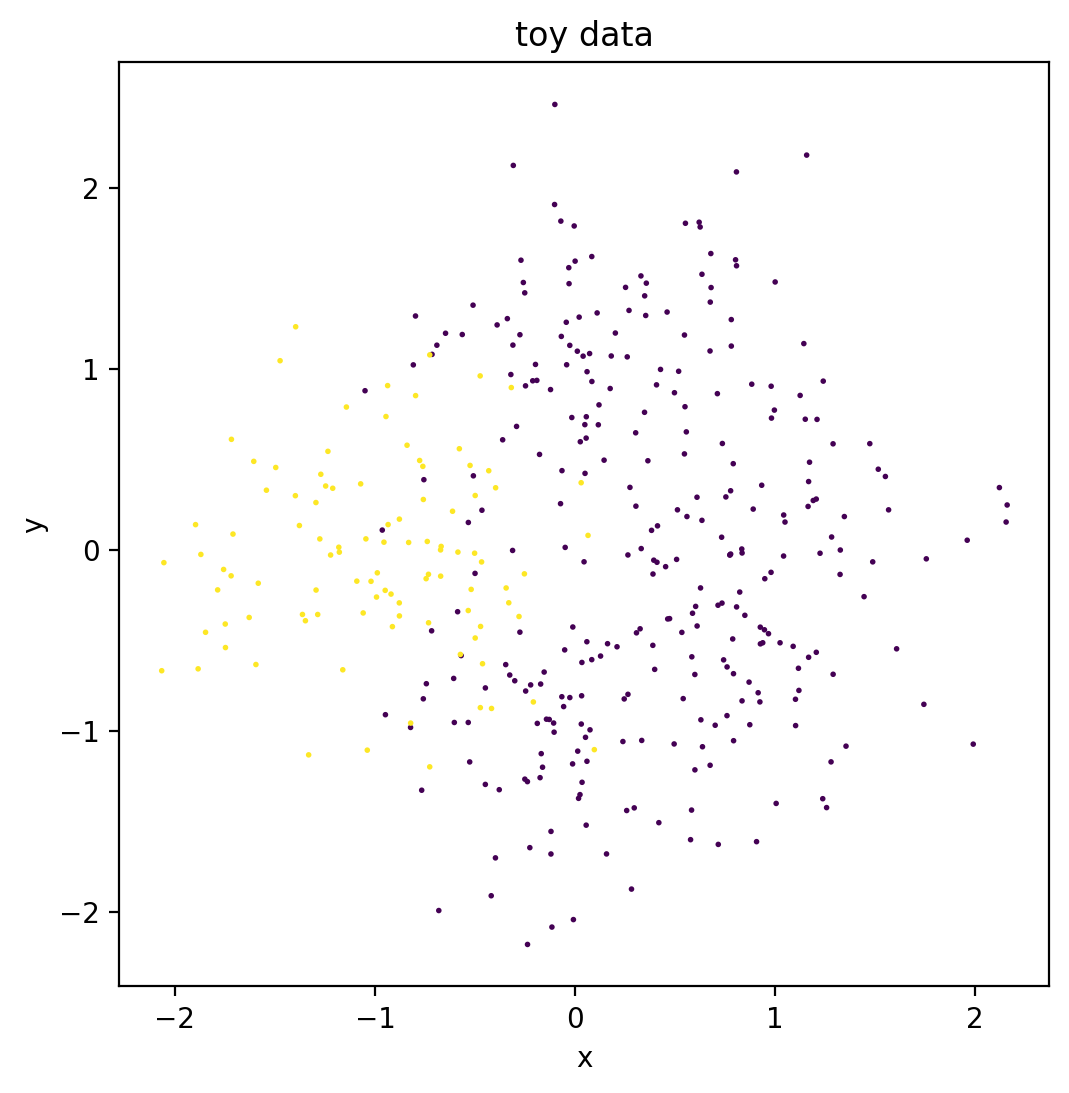

In [4]:
plt.figure(figsize=(6, 6))
plt.title("toy data")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(data[:, 0], data[:, 1], c=labels, s=1)
plt.show()

In [5]:
# Training the model
model = ToyMLP()
model.train(data, labels, epochs=1000, learning_rate=0.01)

Epoch 0: Loss = 0.6834108233451843
Epoch 100: Loss = 0.26033827662467957
Epoch 200: Loss = 0.19681285321712494
Epoch 300: Loss = 0.18172843754291534
Epoch 400: Loss = 0.17609186470508575
Epoch 500: Loss = 0.1713222861289978
Epoch 600: Loss = 0.16752822697162628
Epoch 700: Loss = 0.16603155434131622
Epoch 800: Loss = 0.1648167073726654
Epoch 900: Loss = 0.16384221613407135
Final Loss = 0.16261936724185944


#### Trying to plot its decision boundaries

In [15]:
model_parameters = list(model.parameters())
weights1 = model_parameters[0].detach().numpy()
biases1 = model_parameters[1].detach().numpy()

print(weights1)
print(biases1)

[[ 0.2113915  -0.16707927]
 [ 0.8544633  -0.68624914]
 [ 0.7339891   1.1448122 ]]
[-0.6573023  0.7078591  0.2884745]


In [16]:
# converting the line equation into x and y values
## weight * data + bias = 0  => y_values = - (weight[0] * x_values + bias[0]) / weight[1]
y_value_equation = lambda weight, bias, x: - (weight[0] * x + bias) / weight[1]
x_value_equation = lambda weight, bias, y: - (weight[1] * y + bias) / weight[0]

def define_line(weight, bias, bounds):
    if np.isclose(weight[1], 0): # vertical line
        y = bounds
        x = x_value_equation(weight, bias, y) 
    else:
        x = bounds
        y = y_value_equation(weight, bias, x)

    return x, y

In [17]:
bound = 1.5
bounds = np.array([-bound, bound])
line_points = np.array([define_line(weight, bias, bounds) for weight, bias in zip(weights1, biases1)])
print(line_points)

[[[-1.5         1.5       ]
  [-5.8318998  -2.0362495 ]]

 [[-1.5         1.5       ]
  [-0.83619168  2.89917161]]

 [[-1.5         1.5       ]
  [ 0.7097314  -1.21369963]]]


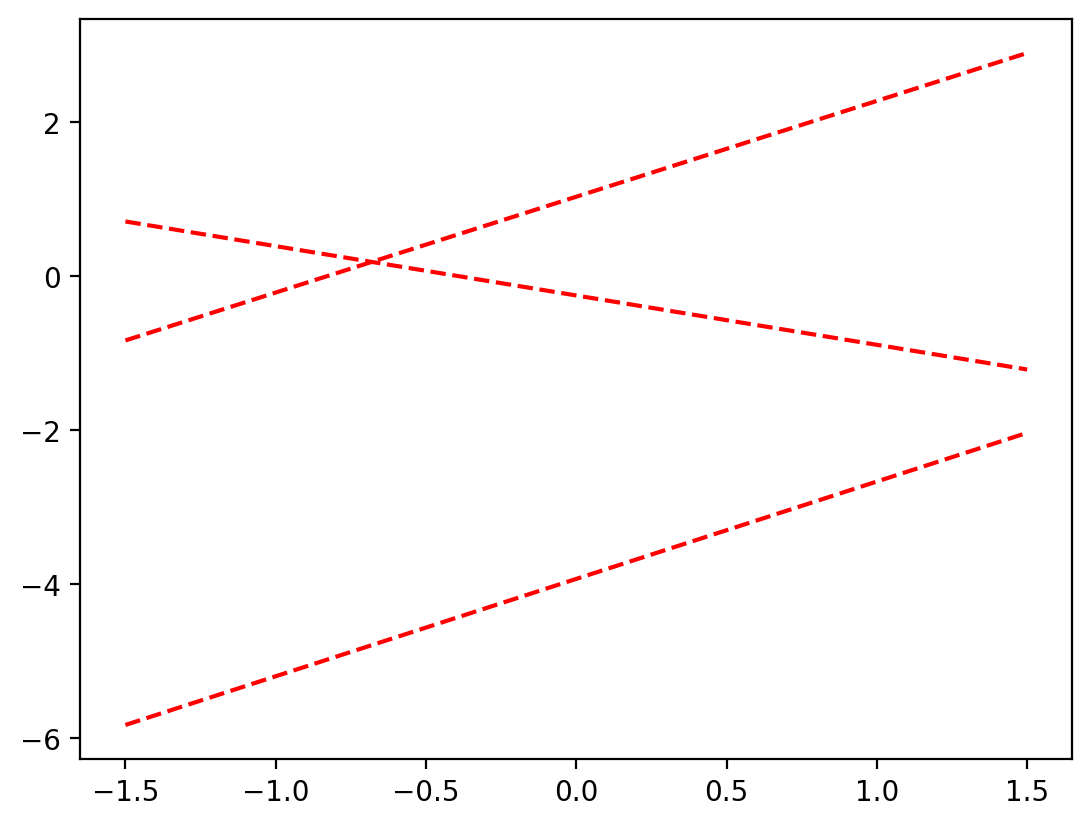

In [ ]:
for i in range(len(line_points)):
    plt.plot(line_points[i, 0], line_points[i, 1], 'r--', label='Decision Boundary')
    

#### Trying it out on the training data

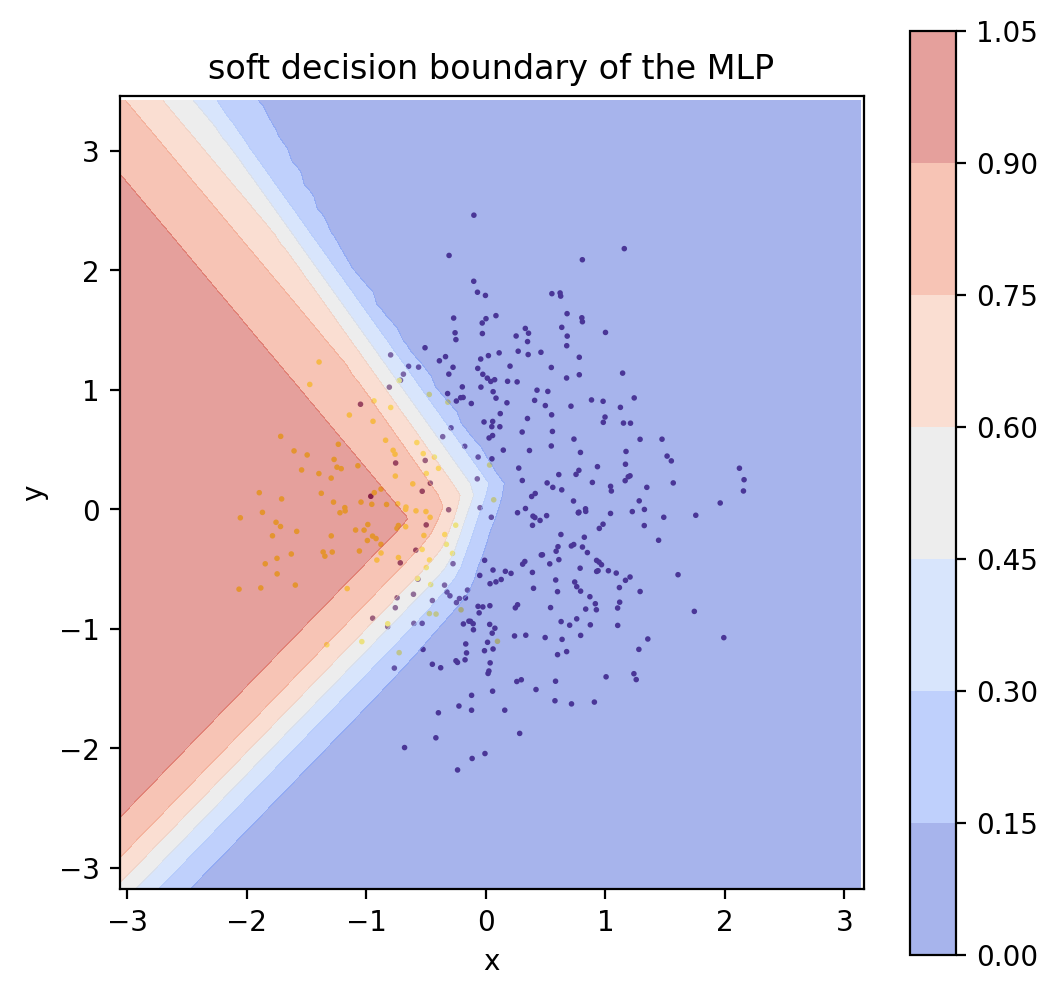

In [6]:
# make test grid
# create a grid of points to classify  
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
#print(f"xx shape: {xx.shape}, yy shape: {yy.shape}")

# convert grid points to tensor
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

labels_grid = model.forward(grid_points).detach().numpy()   # run the soft classification
labels_grid = labels_grid.reshape(xx.shape)   # reshape the labels to match the grid shape   

# plot the soft decision boundary
plt.figure(figsize=(6, 6))
plt.title("soft decision boundary of the MLP")
plt.xlabel("x") 
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.gca().set_aspect('equal')
plt.scatter(data[:, 0], data[:, 1], c=labels, s=1)
plt.contourf(xx, yy, labels_grid, alpha=0.5, cmap='coolwarm')
plt.colorbar()

plt.show()

### Trying it out on real activation data

In [3]:
# repository imports
from utils import DataManager, dataset_sizes, collect_training_data
from probes import learn_truth_directions

In [4]:
# hyperparameters
model_family = 'Llama3'   # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat'   # options are 'chat' or 'base'
layer = 12   # layer from which to extract activations
model_name = f"{model_family}_{model_size}_{model_type}"   # for saving the plots

# define datasets used for training
# the ordering [affirmative_dataset1, negated_dataset1, affirmative_dataset2, negated_dataset2, ...] is required by some functions
train_sets = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors", "neg_inventors", "animal_class",
                  "neg_animal_class", "element_symb", "neg_element_symb", "facts", "neg_facts"]
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 

In [5]:
def collect_affirm_neg_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer):
    dm_affirm, dm_neg = DataManager(), DataManager()
    for dataset_name in train_sets:
        split = min(train_set_sizes.values()) / train_set_sizes[dataset_name]
        if 'neg_' not in dataset_name:
            dm_affirm.add_dataset(dataset_name, model_family, model_size, model_type, layer, split=split, center=False, device='cpu')
        else:
            dm_neg.add_dataset(dataset_name, model_family, model_size, model_type, layer, split=split, center=False, device='cpu')
    return dm_affirm.get('train') + dm_neg.get('train')

def project_activations(acts, t_g, t_p):
    return t_g @ acts.T, t_p @ acts.T

In [6]:
# Compute t_g and t_p using all data
acts_centered, _, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, 
                                                    model_size, model_type, layer)
t_g, t_p = learn_truth_directions(acts_centered, labels, polarities)

In [7]:
acts_affirm, labels_affirm, acts_neg, labels_neg = collect_affirm_neg_data(train_sets, train_set_sizes, 
                                                                            model_family, model_size, 
                                                                            model_type, layer)
activations = np.concatenate([acts_affirm, acts_neg], axis=0)
act_labels = np.concatenate([labels_affirm, labels_neg], axis=0)

# project activations
acts_projected_g, acts_projected_p = project_activations(activations, t_g, t_p)

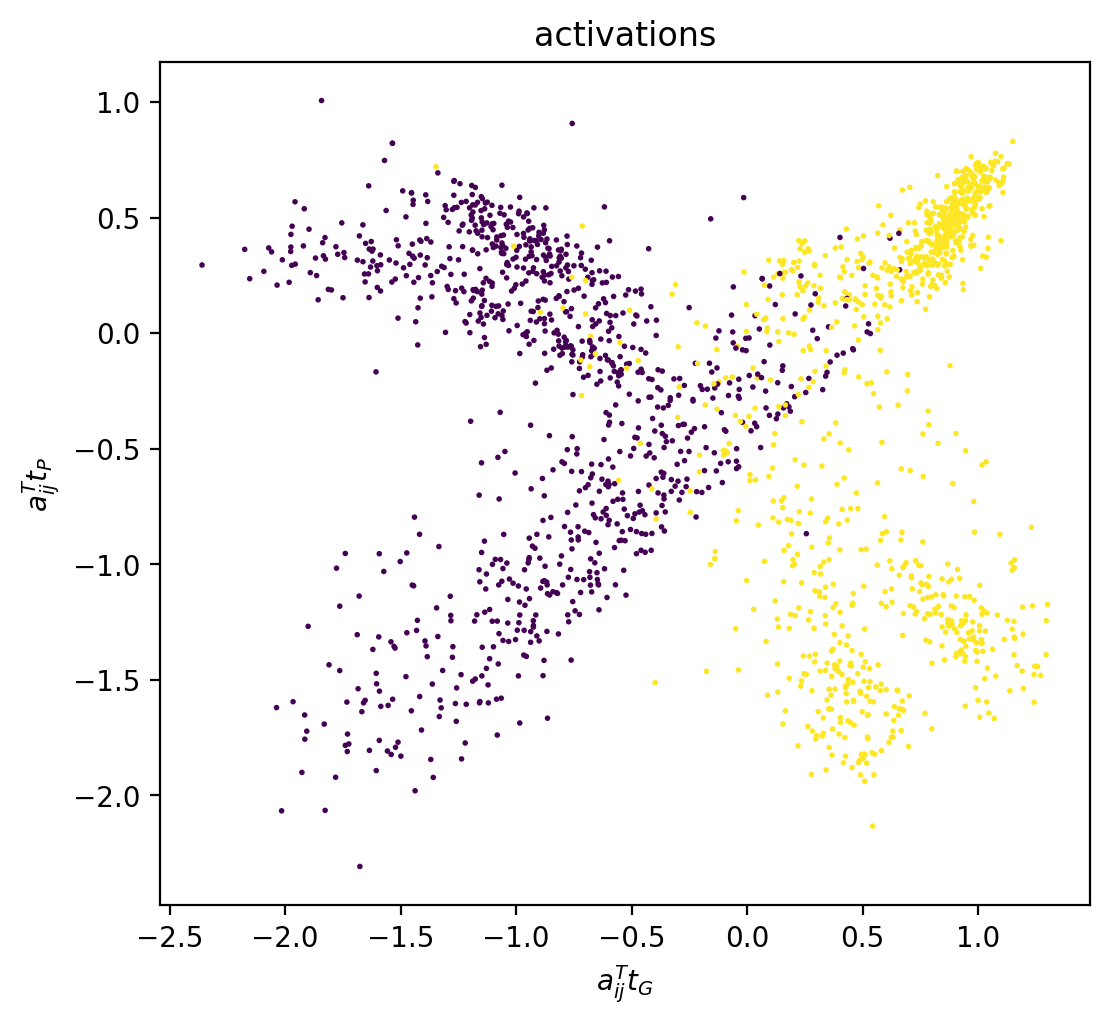

In [8]:
plt.figure(figsize=(6, 6))
plt.title("activations")
plt.xlabel("$a_{ij}^T t_G$")
plt.ylabel("$a_{ij}^T t_P$")
plt.scatter(acts_projected_g, acts_projected_p, c=act_labels, s=1)
plt.gca().set_aspect('equal')

In [9]:
acts_data = np.stack([acts_projected_g, acts_projected_p], axis=1)
real_model = ToyMLP()
real_model.train(acts_data, act_labels)

Epoch 0: Loss = 0.7589414119720459
Epoch 100: Loss = 0.18286611139774323
Epoch 200: Loss = 0.16933436691761017
Epoch 300: Loss = 0.16157248616218567
Epoch 400: Loss = 0.15958324074745178
Epoch 500: Loss = 0.15918129682540894
Epoch 600: Loss = 0.15908248722553253
Epoch 700: Loss = 0.1590159833431244
Epoch 800: Loss = 0.15896350145339966
Epoch 900: Loss = 0.1589142382144928
Final Loss = 0.1588684320449829


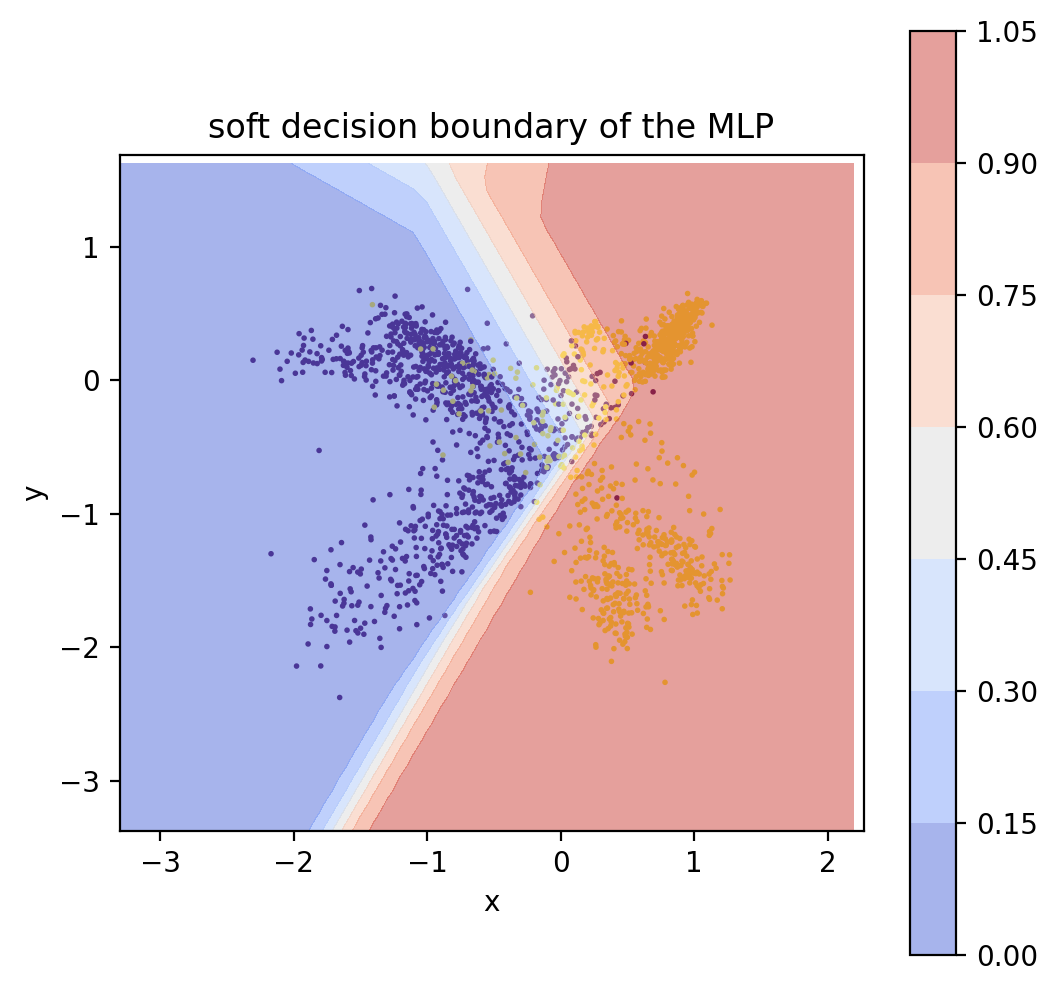

In [10]:
# make test grid
# create a grid of points to classify  
x_min, x_max = acts_data[:, 0].min() - 1, acts_data[:, 0].max() + 1
y_min, y_max = acts_data[:, 1].min() - 1, acts_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
#print(f"xx shape: {xx.shape}, yy shape: {yy.shape}")

# convert grid points to tensor
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

act_labels_grid = real_model.forward(grid_points).detach().numpy()   # run the soft classification
act_labels_grid = act_labels_grid.reshape(xx.shape)   # reshape the labels to match the grid shape   

# plot the soft decision boundary
plt.figure(figsize=(6, 6))
plt.title("soft decision boundary of the MLP")
plt.xlabel("x") 
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.gca().set_aspect('equal')
plt.scatter(acts_data[:, 0], acts_data[:, 1], c=act_labels, s=1)
plt.contourf(xx, yy, act_labels_grid, alpha=0.5, cmap='coolwarm')
plt.colorbar()

plt.show()

### Trying out the `probes.py` implementation

In [1]:
# repository imports
from probes import SimpleMLPProbe

In [9]:
acts_data = np.stack([acts_projected_g, acts_projected_p], axis=1)
probes_model = SimpleMLPProbe()
probes_model.from_data(acts_data, act_labels)

Epoch 0: Loss = 0.7019873857498169
Epoch 100: Loss = 0.1603637933731079
Epoch 200: Loss = 0.15666955709457397
Epoch 300: Loss = 0.15551596879959106
Epoch 400: Loss = 0.15254569053649902
Epoch 500: Loss = 0.14023922383785248
Epoch 600: Loss = 0.13895995914936066
Epoch 700: Loss = 0.13874875009059906
Epoch 800: Loss = 0.13868698477745056
Epoch 900: Loss = 0.13865162432193756
Final Loss = 0.1386217474937439


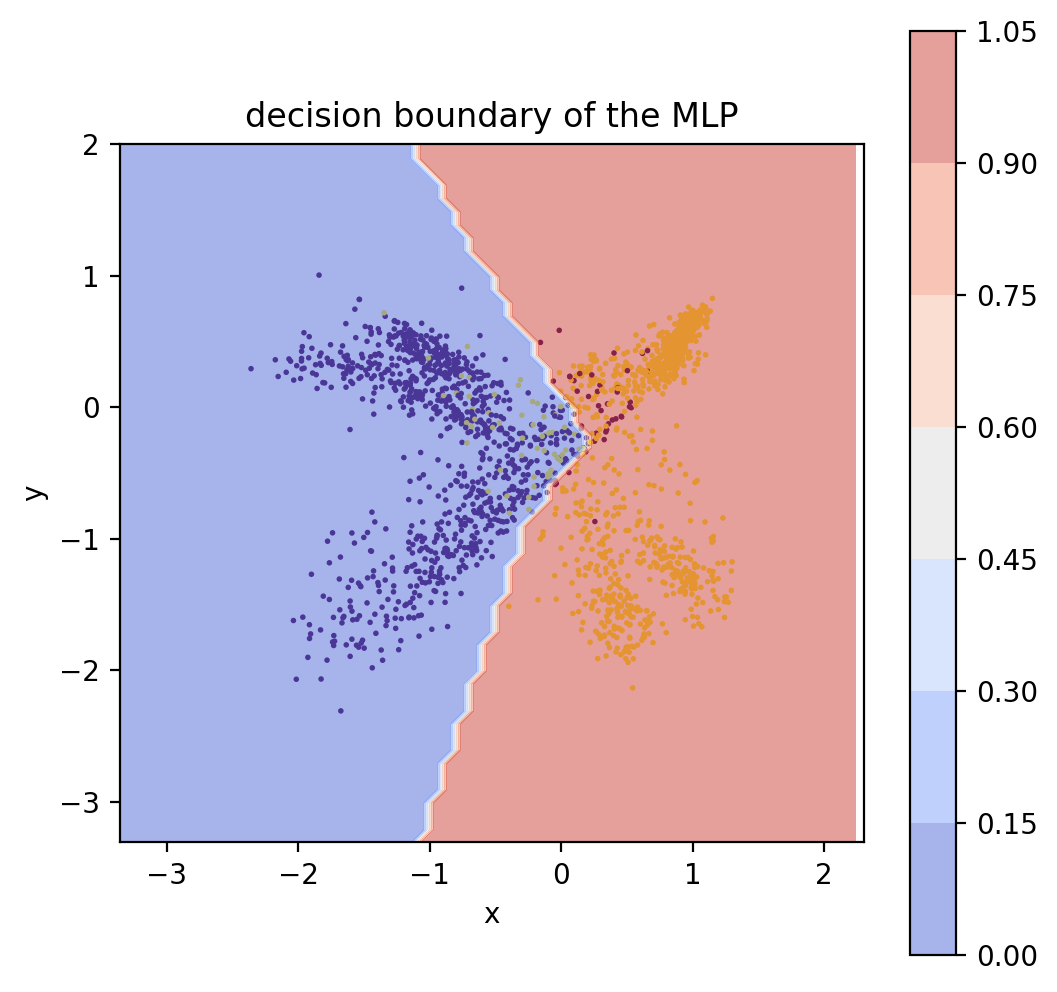

In [11]:
# make test grid
# create a grid of points to classify  
x_min, x_max = acts_data[:, 0].min() - 1, acts_data[:, 0].max() + 1
y_min, y_max = acts_data[:, 1].min() - 1, acts_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
#print(f"xx shape: {xx.shape}, yy shape: {yy.shape}")

# convert grid points to tensor
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

act_labels_grid = probes_model.pred(grid_points).detach().numpy()   # run the classification
act_labels_grid = act_labels_grid.reshape(xx.shape)   # reshape the labels to match the grid shape   

# plot the soft decision boundary
plt.figure(figsize=(6, 6))
plt.title("decision boundary of the MLP")
plt.xlabel("x") 
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.gca().set_aspect('equal')
plt.scatter(acts_data[:, 0], acts_data[:, 1], c=act_labels, s=1)
plt.contourf(xx, yy, act_labels_grid, alpha=0.5, cmap='coolwarm')
plt.colorbar()

plt.show()